# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** YOUR ID HERE ***

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

FileNotFoundError: [Errno 2] No such file or directory: 'training_set.csv'

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

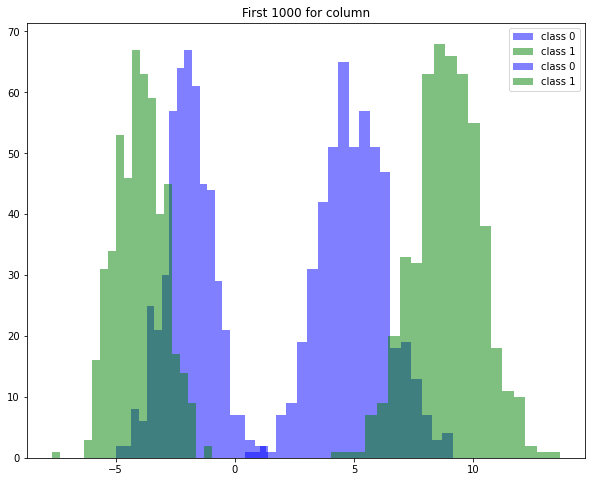

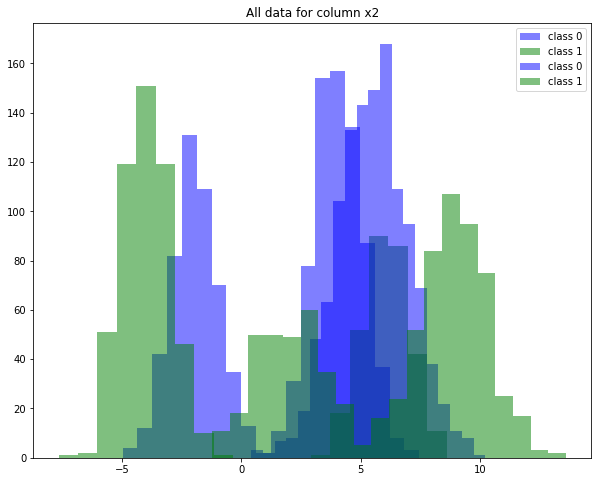

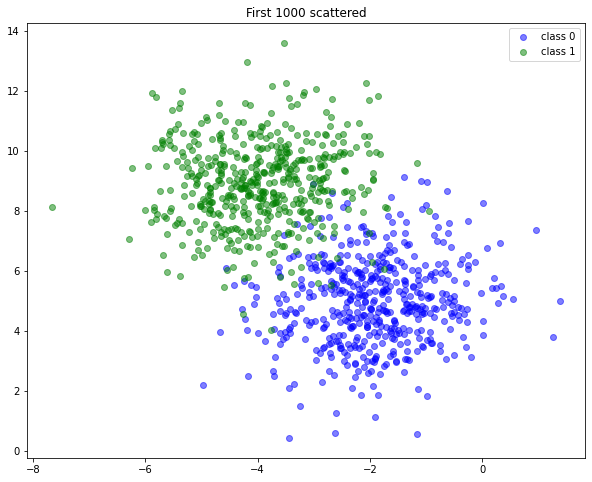

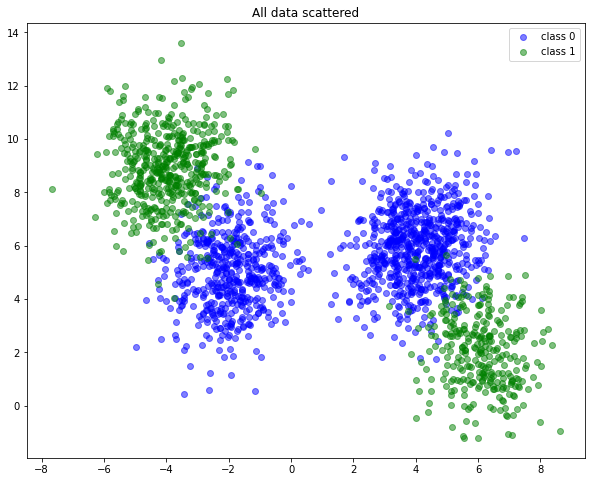

In [ ]:
#### Your code here ####
first_k = training_set.head(1000)
first_k_0 = first_k.loc[first_k['y'] ==0 ]
first_k_1 = first_k.loc[first_k['y'] == 1]
X_0 = first_k_0[['x1', 'x2']].values
X_1 = first_k_1[['x1', 'x2']].values
plt.hist(X_0[:,0], bins = 20, alpha=0.5, label='class 0', color='b')
plt.hist(X_1[:,0], bins = 20, alpha=0.5, label='class 1', color='g')
plt.hist(X_0[:,1], bins = 20, alpha=0.5, label='class 0', color='b')
plt.hist(X_1[:,1], bins = 20, alpha=0.5, label='class 1', color='g')
plt.legend()
plt.title("First 1000 for column")

plt.show()

all_0 = training_set.loc[training_set['y'] ==0 ]
all_1 = training_set.loc[training_set['y'] == 1]
all_X_0 = all_0[['x1', 'x2']].values
all_X_1 = all_1[['x1', 'x2']].values
plt.hist(all_X_0[:,0], bins = 20, alpha=0.5, label='class 0', color = 'b')
plt.hist(all_X_1[:,0], bins = 20, alpha=0.5, label='class 1', color = 'g')
plt.hist(all_X_0[:,1], bins = 20, alpha=0.5, label='class 0', color = 'b')
plt.hist(all_X_1[:,1], bins = 20, alpha=0.5, label='class 1', color = 'g')
plt.legend()
plt.title("All data for column x2")
plt.show()

plt.scatter(X_0[:,0], X_0[:,1], alpha= 0.5, label='class 0', color = 'b')
plt.scatter(X_1[:,0], X_1[:,1], alpha= 0.5, label = "class 1", color='g')
plt.legend()
plt.title("First 1000 scattered")
plt.show()

plt.scatter(all_X_0[:,0],all_X_0[:,1], alpha= 0.5, label='class 0', color = 'b')
plt.scatter(all_X_1[:,0], all_X_1[:,1], alpha= 0.5, label = "class 1", color='g')
plt.legend()
plt.title("All data scattered")
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [ ]:

    
    
def theta_init(X, random_state):
      """ 
      Generate an initial value of vector θ from the original independent variables matrix
      Parameters:
      X:  independent variables matrix
      Return value: a vector of theta filled with initial guess
      """
      np.random.seed(random_state)
      theta = np.random.rand(X.shape[1],1)
      return theta
    
     
      
def sigmoid_function(X ):
  """
  sigmoid function enables hypothesis function to result in a number between 0 and 1
  thetas - the thetas as inputs
  x_i - the (features) of i-th training example 
  """
  return 1.0 /( 1.0 + np.exp( -X ) )
    
   
def cost_function(thetas, X, y):
  h_theta = sigmoid_function(np.dot(X, thetas))
  inner_cost = (np.log(h_theta)*y) + (1-y)*np.log((1-h_theta))
  return np.sum(inner_cost)/-m
  




def gradient(thetas, X, y):
  m = X.shape[0]
  hyp = (sigmoid_function(np.dot(X, thetas))) - y
  return (1.0/ m) * np.dot(X.T, hyp)
    

In [ ]:
X = X_training.copy()
m = X.shape[0]
np.column_stack([np.ones(m), X])

array([[ 1.        , -1.38578869,  9.13146361],
       [ 1.        , -2.23690338,  5.56117803],
       [ 1.        , -2.3625238 ,  5.2159729 ],
       ...,
       [ 1.        ,  7.42420048,  1.77493117],
       [ 1.        ,  6.67073987,  0.33570079],
       [ 1.        ,  4.16906648,  1.64874303]])

In [ ]:
class LogisticRegressionGD(object):
  
  
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1, predict =None):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.thetas = None
        self.cost_list = []
        

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        m = X.shape[0]
        vectorX = np.column_stack([np.ones(m), X])
         
        y = np.reshape(y, (m, 1))
        
        self.thetas = theta_init(vectorX, self.random_state)
        for i in range(self.n_iter):
          self.cost_list.append(cost_function(self.thetas, vectorX, y ))
          self.thetas = self.thetas - ( self.eta * gradient(self.thetas, vectorX, y) )
          if(len(self.cost_list) > 1):
            if(np.abs(self.cost_list[-2] - self.cost_list[-1]) < self.eps):
              break
        

              
          
        
    
    def predict(self, X):
        """Return the predicted class label"""
        m = X.shape[0]
        X = np.column_stack([np.ones(m), X])
        predictions = sigmoid_function(np.dot(X, self.thetas))
        return np.round_(predictions)
        
    

    def get_Accuracy(self, data, labels):
        labels = np.reshape(labels, (labels.shape[0], 1))
        count = self.predict(data) == labels
        return np.count_nonzero(count) / count.shape[0]
            
      
    


In [ ]:
#testing
lrgd_test = LogisticRegressionGD(eta=0.05, eps=0.01, n_iter=10000, random_state=2)
lrgd_test.fit(X_training[:1000], y_training[:1000])
lrgd_test.get_Accuracy(X_test, y_test)


0.405

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [ ]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

training_set_copy = training_set.copy()
training_set_copy = training_set_copy.sample(frac=1).reset_index(drop=True) # shuffle dataframe
m = len(training_set_copy.index)
train_set0 = training_set_copy[0:int(m*0.2):] 
train_set1 = training_set_copy[int(m*0.2):int(m*0.4):] 
train_set2 = training_set_copy[int(m*0.4):int(m*0.6):] 
train_set3 = training_set_copy[int(m*0.6):int(m*0.8):] 
train_set4 = training_set_copy[int(m*0.8)::]  

train_x0 , train_y0 = train_set0[['x1', 'x2']].values, train_set0['y'].values
train_x1 , train_y1 = train_set1[['x1', 'x2']].values, train_set1['y'].values
train_x2 , train_y2 = train_set2[['x1', 'x2']].values, train_set2['y'].values
train_x3 , train_y3 = train_set3[['x1', 'x2']].values, train_set3['y'].values
train_x4 , train_y4 = train_set4[['x1', 'x2']].values, train_set4['y'].values



def avg_Accuracy(eta, eps):
    X_folds = [train_x0, train_x1, train_x2, train_x3, train_x4]
    y_folds = [train_y0, train_y1, train_y2, train_y3, train_y4]
    accuracys = []
    for i in range(0, 5):
        temp_X = X_folds.copy()
        temp_y = y_folds.copy()
        X_training = temp_X.pop(i)
        y_training = temp_y.pop(i)
        X_test = np.vstack(temp_X)
        y_test = np.concatenate(temp_y)
        lrgd_test = LogisticRegressionGD(eta=eta, eps=eps, n_iter=2000, random_state=2)
        lrgd_test.fit(X_training, y_training)
        print(f"    -finneshed fitting for fold {i}")
        accuracys.append(lrgd_test.get_Accuracy(X_test, y_test))
        print(f"    -finneshed accuracy for fold {i}")
    return sum(accuracys)/5

def get_best_etas_epss(etas, epss):
    etas_i_epss_j_avg = []
    etas_i_epss_j_index = []
    
    for i in range(5):
        for j in range(5):
            print(f"eta is {etas[i]} and eps is {epss[j]} ")
            etas_i_epss_j_avg.append(avg_Accuracy(etas[i],epss[j]))
            etas_i_epss_j_index.append([i,j])
            print(f"for eps {etas[i]}, and eps {epss[j]} the avrage accuracy is {etas_i_epss_j_avg[-1]}")
    index = etas_i_epss_j_avg.index(max(etas_i_epss_j_avg))
    pair = etas_i_epss_j_index[index]
    return etas[pair[0]], epss[pair[1]]

answer = get_best_etas_epss(etas, epss) 
best_eta, best_epss = answer  

        
    
    

eta is 0.05 and eps is 0.01 
    -finneshed fitting for fold 0
    -finneshed accuracy for fold 0
    -finneshed fitting for fold 1
    -finneshed accuracy for fold 1
    -finneshed fitting for fold 2
    -finneshed accuracy for fold 2
    -finneshed fitting for fold 3
    -finneshed accuracy for fold 3
    -finneshed fitting for fold 4
    -finneshed accuracy for fold 4
for eps 0.05, and eps 0.01 the avrage accuracy is 0.5836250000000001
eta is 0.05 and eps is 0.001 
    -finneshed fitting for fold 0
    -finneshed accuracy for fold 0
    -finneshed fitting for fold 1
    -finneshed accuracy for fold 1
    -finneshed fitting for fold 2
    -finneshed accuracy for fold 2
    -finneshed fitting for fold 3
    -finneshed accuracy for fold 3
    -finneshed fitting for fold 4
    -finneshed accuracy for fold 4
for eps 0.05, and eps 0.001 the avrage accuracy is 0.560375
eta is 0.05 and eps is 0.0001 
    -finneshed fitting for fold 0
    -finneshed accuracy for fold 0
    -finneshed fitting

In [ ]:
#test
best_eta, best_epss

(0.05, 1e-06)

## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [ ]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return np.exp(-0.5 * np.square(data - mu) / np.square(sigma)) / np.sqrt(2 * np.pi * np.square(sigma))

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [ ]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=1, responsibilities = None, probs =None ):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.weights = np.empty(self.k)
        self.mus = np.empty(self.k)
        self.sigmas = np.empty(self.k)
        self.responsibilities = responsibilities
        self.probs = probs
        self.data_split = None
        self.cost_history =None

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(self.random_state)
        
        self.weights = np.random.random(self.k)
        self.weights = self.weights/np.sum(self.weights) # make the sum of the weights will be 1
                
        self.data_split = np.array_split(data, self.k)
        
        self.mus = np.empty(self.k,)
        self.sigmas = np.empty(self.k,)
        for j in range(self.k):
          self.mus[j] = np.mean(self.data_split[j])
          self.sigmas[j] = np.std(self.data_split[j])
        
      
        self.probs = np.empty([self.k, data.shape[0]])
        
        
    def expectation(self, data):
        """
        E step - calculating responsibilities

        """
        self.probs = np.array([norm_pdf(data, self.mus[i], self.sigmas[i])*self.weights[i] for i in range(self.k)])
        self.responsibilities = self.probs / np.sum(self.probs, axis=0)
        

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        N_num_of_instances = data.shape[0]
        
        
        self.weights = np.sum(self.responsibilities, axis = 1) * (1.0/ N_num_of_instances)
    
        for j in range(0,self.k):
          self.mus[j] = (1.0 / (self.weights[j] * N_num_of_instances)) * np.mean(np.dot(self.responsibilities[j], data))
          subed = data.copy() - self.mus[j]
          self.sigmas[j] = (1.0 / (self.weights[j] * N_num_of_instances)) * np.dot( self.responsibilities[j] , np.multiply(subed, subed) )

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        self.cost_history = []
        for i in range(0,self.n_iter):
          self.expectation(data)
          self.maximization(data)
          self.cost_history.append(self.compute_cost())
          if len(self.cost_history) > 1 :
            if self.cost_history[-2] - self.cost_history[-1] < self.eps:
              break
        

    def get_dist_params(self):
        return self.mus, self.sigmas, self.weights
    def compute_cost_individual(self, c):
        inner = np.log(np.dot(self.weights[c], self.probs[c]))  * -1.0
        print(inner.shape)


        return sum(inner)

    def compute_cost(self):
        #create a list of the wights*pdf for each gausian 
        weight_mul_pdf = np.array([self.probs[i] for i in range(self.k)])
        
        cost = np.sum(np.sum(-np.log(i)) for i in weight_mul_pdf)
        return cost
        
      
        
    

      

In [ ]:
#test
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values


In [ ]:
#test
data = X_training[:,0].copy()
test_EM = EM(k=2, n_iter=10000, eps=0.0000000000000001)
history = test_EM.fit(data)



## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [ ]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=1, classes=None, prior=None, mus=None, sigmas=None, weights=None ):
        self.k = k
        self.random_state =random_state
        self.classes = classes
        self.prior = prior
        self.mus = mus
        self.sigmas = sigmas
        self.weights = weights

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.classes, count = np.unique(y, return_counts = True)
        self.prior = count/np.sum(count)
        K = self.classes.shape[0]
        N = X.shape[1] 
        data_subset_list =[X[np.where(y == self.classes[i])] for i in range(0,K)] 
        self.mus, self.sigmas, self.weights = np.empty( [K, N, self.k] ), np.empty( [K, N, self.k] ), np.empty( [K, N, self.k] )
        for i in range(K):
          #for each label
          current_data_subset = data_subset_list[i].copy()
          for j in range(N):
            #for each column in that label
            current_Column = current_data_subset[:,j].copy()
            current_EM = EM(k=self.k, random_state=self.random_state)
            current_EM.fit(current_Column)
            self.mus[i][j], self.sigmas[i][j], self.weights[i][j] = current_EM.get_dist_params()
            

        
    def get_likelihood(self, X, c):
        """
        X: 
          instance of test_data 
        c: 
          class label index within data 
        returns combined probabilaty of all gaussians weighted by given weights
        """
        current_mus = self.mus[c]
        current_sigmas = self.sigmas[c]
        current_weights = self.weights[c]
        prob = 1
        prob_per_column = 0
        for i in range(self.mus.shape[1]):
          # iterate over columns
          prob_per_column = 0
          for j in range(self.k):
            #iterate over gaussians
            prob_per_column += norm_pdf(X[i], current_mus[i][j], current_sigmas[i][j]) * current_weights[i][j]  
            #print(f"  for column {i}, gaussian {j} the prob is {prob_per_column}")
          prob *= prob_per_column
        #print(f"for class {c}, the probabilaty of {self.classes[c]} is {prob}")  
        return prob * self.prior[c]

    def predict_instance(self, X):
        """Return the predicted class label"""
        pred = [self.get_likelihood(X, index) for index in range(len(self.classes))]
        class_index = np.argmax(pred)
        return self.classes[class_index]
        
    def predict(self,data):
        predictions = np.array(
          [self.predict_instance(row) for row in data]
        )
        return predictions
    def get_Accuracy(self, data, labels):
        count = self.predict(data) == labels
        return np.count_nonzero(count) / count.shape[0]
      

In [ ]:
#test
test_NB = NaiveBayesGaussian(k=4)
test_NB.fit(X_training, y_training)
test_NB.get_Accuracy( X_test, y_test)



0.874

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

Logistic Regression accuracy for the first 500 points of test is: 0.938
Logistic Regression accuracy for the all points of test is: 0.792
NB accuracy for the first 500 points of test is: 0.936
NB accuracy for all the points of test is: 0.874


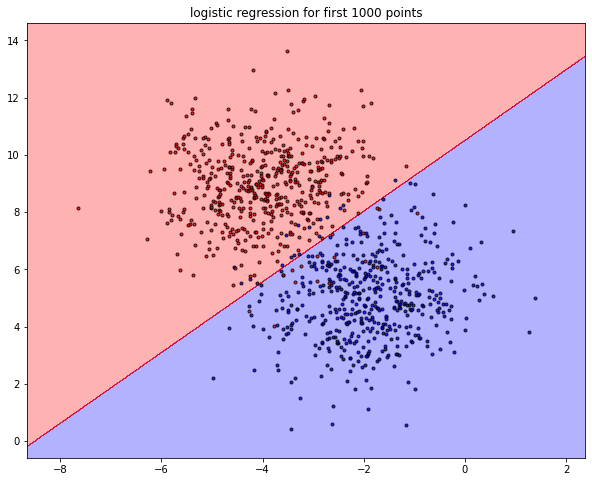

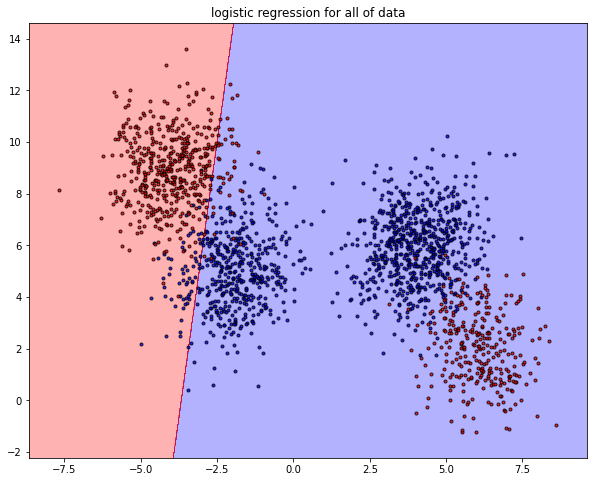

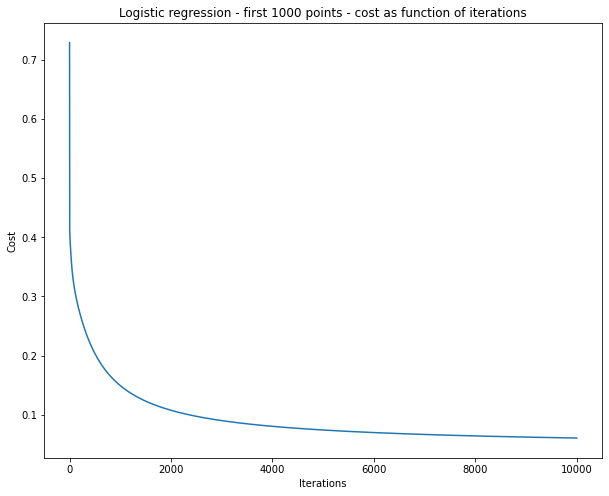

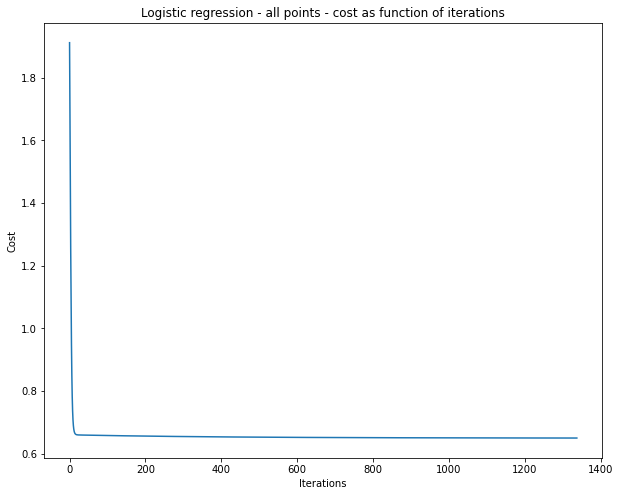

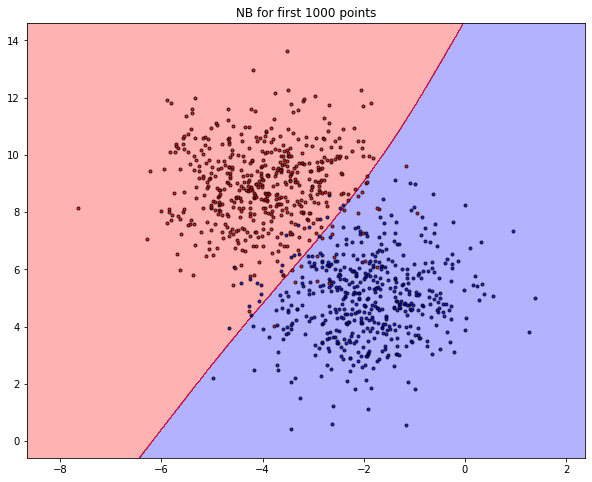

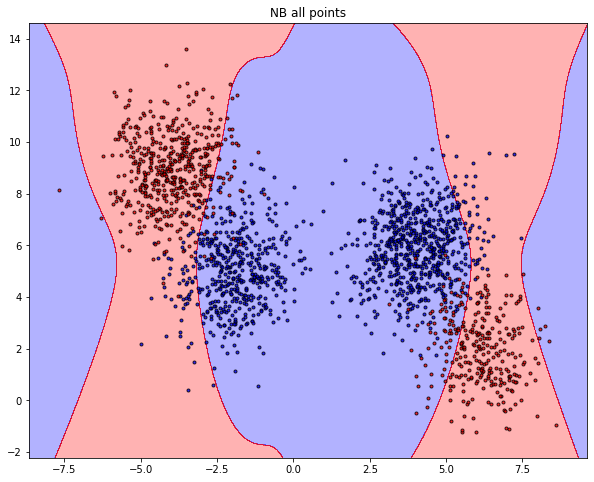

In [ ]:
#### Your code here ####
first_1000_X_training = X_training[:1000].copy()
first_1000_y_training = y_training[:1000].copy()

first_500_X_test = X_test[:500].copy()
first_500_y_test = y_test[:500].copy()

logistic_train = LogisticRegressionGD(eta=best_eta, eps=best_epss)
logistic_train.fit(first_1000_X_training,first_1000_y_training)
logistic_train_all = LogisticRegressionGD(eta=best_eta, eps=best_epss)
logistic_train_all.fit(X_training, y_training)

NB_train = NaiveBayesGaussian(k=2)
NB_train.fit(first_1000_X_training, first_1000_y_training)
NB_train_all = NaiveBayesGaussian(k=4)
NB_train_all.fit(X_training, y_training)

logistic_test_accurcy = logistic_train.get_Accuracy(first_500_X_test,first_500_y_test)
logistic_test_accurcy_all = logistic_train_all.get_Accuracy(X_test, y_test)
NB_train_accuracy = NB_train.get_Accuracy(first_500_X_test, first_500_y_test)
NB_train_accuracy_all = NB_train_all.get_Accuracy(X_test, y_test)
print(f"Logistic Regression accuracy for the first 500 points of test is: {logistic_test_accurcy}")
print(f"Logistic Regression accuracy for the all points of test is: {logistic_test_accurcy_all}")
print(f"NB accuracy for the first 500 points of test is: {NB_train_accuracy}")
print(f"NB accuracy for all the points of test is: {NB_train_accuracy_all}")

plot_decision_regions(first_1000_X_training, first_1000_y_training, logistic_train)
plt.title("logistic regression for first 1000 points")
plt.show()
plot_decision_regions(X_training, y_training, logistic_train_all)
plt.title("logistic regression for all of data")
plt.show()

plt.plot(range(len(logistic_train.cost_list)), logistic_train.cost_list)
plt.title("Logistic regression - first 1000 points - cost as function of iterations")
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

plt.plot(range(len(logistic_train_all.cost_list)), logistic_train_all.cost_list)
plt.title("Logistic regression - all points - cost as function of iterations")
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

plot_decision_regions(first_1000_X_training, first_1000_y_training, NB_train)
plt.title("NB for first 1000 points")
plt.show()

plot_decision_regions(X_training, y_training, NB_train_all)
plt.title("NB all points")
plt.show()

Summery of graphs:
1) Logistic regression for first 1000 points: The logstical regression fro the first 1000 points has an impressive accuracy because the data does have a strong coveriance for each label and is not that scattered.
2) Logistic regression for all of data: The accuracy is lower because the converiance is pretty low and the two labels don'y converge to one point but more like two.
3) Logistic regression - first 1000 points - cost as function of iterations: The graph does take a while to converge on the final cost due to the fact that the data is fitting for logistical regression and so through iterration we can get more accurate.
4) Logistic regression - all points - cost as function of iterations: The graph gets pretty close to its final accuracy quit fast because the data does not fit logisitical regression very well and so after a sertain point the model can not get better.
5) NB for first 1000 points: The accuracy is pretty good because the two label do not overlap much and as such the model can easly find two gaussians that each fit a label.
6) NB for all data: The accuracy is much better than that of logistical regression because the NB EM algoitham suits the data that for each label converges on two points better.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


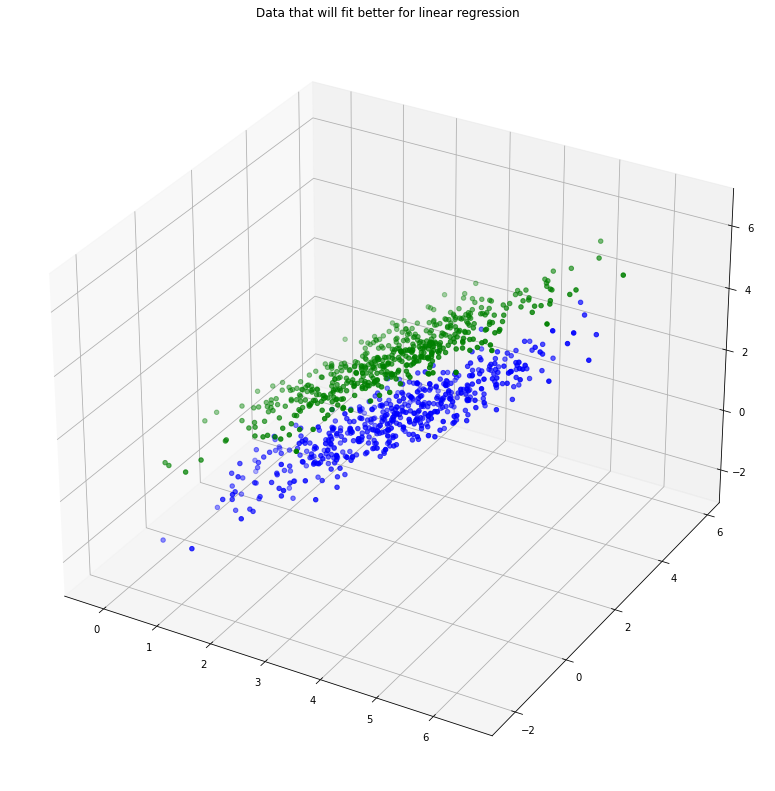

In [ ]:
cov1_1 = np.array([[1 , -1, 1], [1, 1, 1], [1, 1, 1]])
mu1_1 = np.array([3, 2, 3])
r1_1 = np.random.multivariate_normal(mean = mu1_1, cov = cov1_1, size =500)

cov2_1 = np.array([[1 , 1, 0.9], [0.9, 1, 1], [1, 0.9, 1]])
mu2_1 = np.array([3, 2, 1])
r2_1 = np.random.multivariate_normal(mean = mu2_1, cov = cov2_1, size =500)
fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")


ax.scatter3D(r1_1[:,0], r1_1[:,1], r1_1[:,2], color = "green")

ax.scatter3D(r2_1[:,0], r2_1[:,1], r2_1[:,2], color = "blue")
plt.title("Data that will fit better for linear regression")
plt.show()

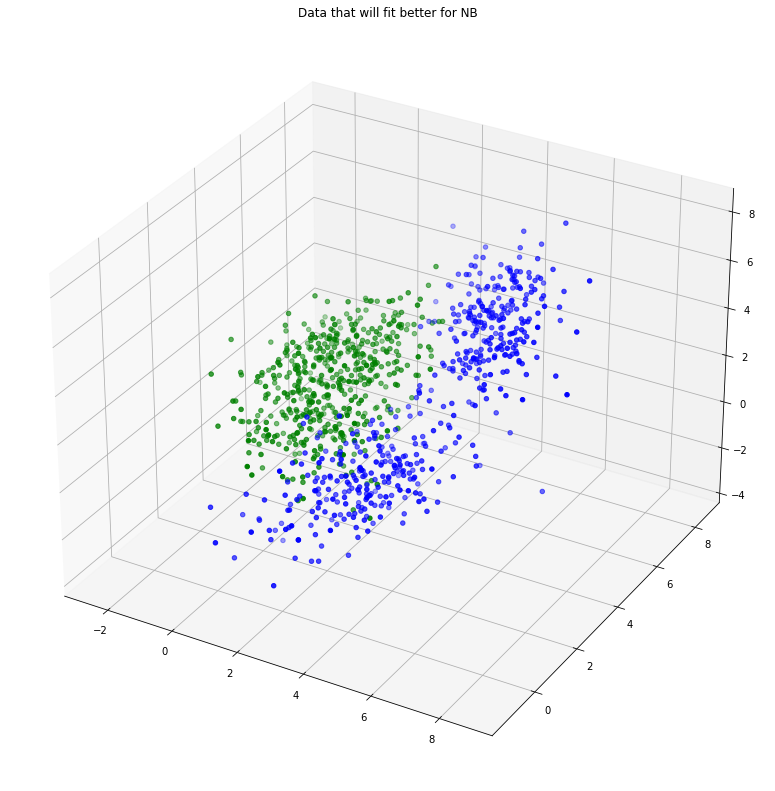

In [ ]:
#present the data for NB
cov1 = np.array([[1 , -0.5, 0.6], [0.5, 1, 0.3], [0.2, 0.4, 1]])
mu1 = np.array([0, 6, 1])
r1 = np.random.multivariate_normal(mean = mu1, cov = cov1, size =250)

cov2 = np.array([[1 , 0.2, 0.9], [0.9, 1, 0.1], [0.4, 0.9, 1]])
mu2 = np.array([3, 2, 0])
r2 = np.random.multivariate_normal(mean = mu2, cov = cov2, size =250)

cov1 = np.array([[1 , 0.5, -0.6], [-0.5, 1, 0.3], [0.2, 0.4, 1]])
mu1 = np.array([1, 3, 1])
r3 = np.random.multivariate_normal(mean = mu1, cov = cov1, size =250)

cov2 = np.array([[1 , -0.2, 0.9], [0.9, -1, 0.1], [-0.4, 0.9, 1]])
mu2 = np.array([5, 5, 5])
r4 = np.random.multivariate_normal(mean = mu2, cov = cov2, size =250)

fig = plt.figure(figsize = (20, 14))
ax = plt.axes(projection ="3d")


ax.scatter3D(r1[:,0], r1[:,1], r1[:,2], color = "green")
ax.scatter3D(r2[:,0], r2[:,1], r2[:,2], color = "blue")
ax.scatter3D(r3[:,0], r3[:,1], r3[:,2], color =  "green" )
ax.scatter3D(r4[:,0], r4[:,1], r4[:,2], color = "blue")
plt.title("Data that will fit better for NB")
plt.show()

In [ ]:
X_for_LR = np.vstack((r1_1, r2_1))

y_r1 = np.zeros(r1_1.shape[0])
y_r2 = np.ones(r2_1.shape[0])
y_for_LR= np.concatenate((y_r1,y_r2))

X_for_NB = np.vstack((r1,r2,r3,r4))


y_r1 = np.zeros(r1.shape[0])
y_r2 = np.ones(r2.shape[0])
y_r3 = np.zeros(r3.shape[0])
y_r4 = np.ones(r4.shape[0])
y_for_NB= np.concatenate((y_r1,y_r2, y_r3, y_r4))

LR_test_LR_data = LogisticRegressionGD(eta=best_eta, eps=best_epss )
LR_test_LR_data.fit(X_for_LR, y_for_LR)
NB_test_LR_data =  NaiveBayesGaussian(k=2)
NB_test_LR_data.fit(X_for_LR, y_for_LR)

LR_test_NB_data = LogisticRegressionGD(eta=best_eta, eps=best_epss)
LR_test_NB_data.fit(X_for_NB, y_for_NB)
NB_test_NB_data = NaiveBayesGaussian(k=2)
NB_test_NB_data.fit(X_for_NB, y_for_NB)

In [ ]:
lrlr = LR_test_LR_data.get_Accuracy(X_for_LR, y_for_LR)
nblr = NB_test_LR_data.get_Accuracy(X_for_LR, y_for_LR)
lrnb = LR_test_NB_data.get_Accuracy(X_for_NB, y_for_NB)
nbnb = NB_test_NB_data.get_Accuracy(X_for_NB, y_for_NB)
print(f"With regard to the first data set the accuracy of LR is {lrlr} and that of NB is {nblr}, as expected the data favores LR ")
print(f"with regard to the second data set the accuracy of Lr is {lrnb} and that of NB is {nbnb}, as expceted while the margin is small the data does favor NB. ")

With regard to the first data set the accuracy of LR is 0.999 and that of NB is 0.848, as expected the data favores LR 
with regard to the second data set the accuracy of Lr is 0.93 and that of NB is 0.934, as expceted while the margin is small the data does favor NB. 
